In [1]:
import numpy as np
import cairo
from random import random, choice
import matplotlib.pyplot as plt
import torch

c:\Users\adinakar\Anaconda3\envs\astro\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from itertools import product
colors = list(product((0,1), (0,1), (0,1)))[1:]

In [3]:
def make_star(w=200, h=200):
  img = np.zeros(shape=(h, w), dtype=np.uint32)
  with cairo.ImageSurface.create_for_data(img, cairo.FORMAT_ARGB32, w, h) as surface:
      context = cairo.Context(surface)
      context.set_antialias(cairo.Antialias.BEST)
      context.set_source_rgb(0,0,0)
      context.fill()
      x1, y1 = random(), random()
      x2, y2 = random(), random()
      r = random()
      print(f"c1:{x1},{y1}, c2:{x2},{y2}, r:{r}")
      pat = cairo.RadialGradient(x1, y1, 0, x2, y2, r)
      pat.set_matrix(cairo.Matrix(xx=1/w, yy=1/h))
      pat.add_color_stop_rgb(0, *choice(colors))
      pat.add_color_stop_rgb(1, 0, 0, 0)
      context.set_source(pat)
      context.scale(w, h)
      context.rectangle(0, 0, 1, 1)
      context.fill()
  r=(img >>16) & 0xff
  g=(img >>8) & 0xff
  b=img & 0xff
  return np.stack([r.astype(np.uint8),g.astype(np.uint8),b.astype(np.uint8)], axis=2)

img = make_star()

c1:0.052355631812104786,0.7960064718463621, c2:0.516493844303243,0.956897613112126, r:0.79357620578943


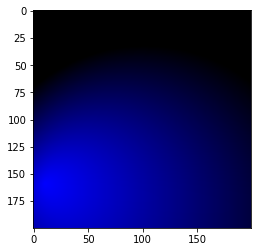

In [4]:
plt.imshow(img)

In [5]:
def rggb(img):
  r_m = np.zeros(shape=img.shape[:2], dtype=np.uint8)
  r_m[0::2, 0::2] = 1
  g1_m = np.zeros(shape=img.shape[:2], dtype=np.uint8)
  g1_m[0::2, 1::2] = 1
  g2_m = np.zeros(shape=img.shape[:2], dtype=np.uint8)
  g2_m[1::2, 0::2] = 1
  b_m = np.zeros(shape=img.shape[:2], dtype=np.uint8)
  b_m[1::2, 1::2] = 1

  return (img[:,:,0] * r_m) + (img[:,:,1] * g1_m) + (img[:,:,1] * g2_m) + (img[:,:,2] * b_m)

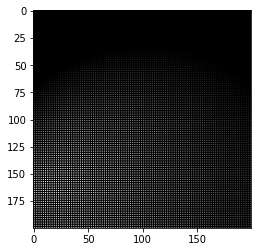

In [6]:
img_rggb = rggb(img)
plt.imshow(img_rggb, cmap='gray')

In [7]:
plt.imsave('test_rggb.png', img_rggb, dpi=300, cmap='gray')

In [8]:
img_rggb.dtype

dtype('uint8')

In [9]:
import bilinear
output_img = bilinear.debayer_bilinear(img_rggb)

d:\code\astrocam\debayer\bilinear.py:17: RuntimeWarning: invalid value encountered in true_divide
  img = img / np.max(img)


In [10]:
output_img.dtype

dtype('float32')

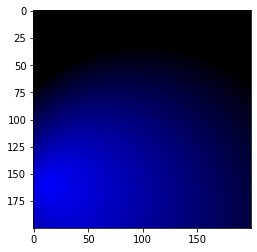

In [11]:
plt.imshow(output_img)

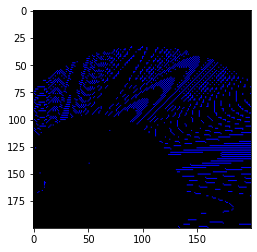

In [12]:
plt.imshow((output_img * 255).astype(np.uint8)-img)

In [13]:
import torch
import importlib
from pathlib import Path

run_path = Path("../mlruns/0/cba518c62db649dfb2c4bd41ce4573ff/artifacts")
cls_path = run_path / "/debayer_model.py"
mod_type = importlib.import_module("debayer_model", cls_path)

In [14]:
dm = mod_type.DebayerModel()
dm.load_state_dict(torch.load(run_path / "weights_00019.pth"))

<All keys matched successfully>

In [15]:
bayered = img_rggb.astype(np.float32)
bayered = np.expand_dims(np.expand_dims(bayered, axis=0), axis=0)
bayered = bayered / 255.0

In [16]:
bayered.shape

(1, 1, 200, 200)

In [17]:
rgb_f = dm(torch.tensor(bayered))

In [18]:
rgb_i = (rgb_f * 255.0).detach().numpy().astype(np.uint8)

In [19]:
rgb_i.shape

(1, 3, 200, 200)

In [20]:
rgb_img = np.transpose(rgb_i[0], axes=(1, 2, 0))
print(rgb_img.shape)

(200, 200, 3)


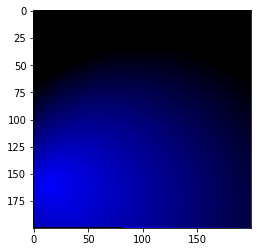

In [21]:
plt.imshow(rgb_img)

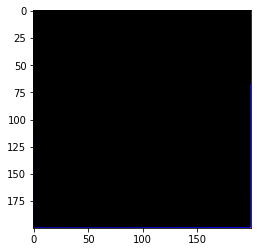

In [22]:
plt.imshow((output_img * 255).astype(np.uint8)-rgb_img)